In [1]:
### ------------------------------- ###
### MovieLens Analysis ###
### Author: Asim Jamal ###
### Dataset link : https://files.grouplens.org/datasets/movielens/ml-100k.zip ###
### ------------------------------- ###

In [2]:
#Installing Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import plotly.express as px
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import linregress
import networkx as nx
import re
import os

In [3]:
# ------------------------------
# Load Data
# ------------------------------
# u.data: user_id, item_id, rating, timestamp
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# u.item: movie_id | title | release_date | video_release | imdb_url | genres...
movies = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None)
movies = movies.iloc[:, :24]  # first 24 cols only
movies.columns = ["movie_id", "title", "release_date", "video_release", "imdb_url"] + [f"genre_{i}" for i in range(19)]

In [4]:
# Merge ratings with movie info
data = ratings.merge(movies[["movie_id", "title", "release_date"]], on="movie_id")

# Convert release_date to year
data["year"] = pd.to_datetime(data["release_date"], errors="coerce").dt.year

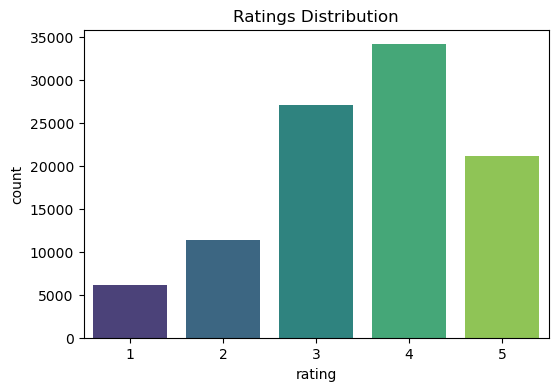

In [5]:
# ------------------------------
# 1. Rating distribution
# ------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=data, palette="viridis")
plt.title("Ratings Distribution")
plt.show()

In [6]:
# ------------------------------
# 2. Top/Bottom 10 movies by avg rating (min 50 ratings)
# ------------------------------
movie_stats = data.groupby("title").agg(
    avg_rating=("rating","mean"),
    n_ratings=("rating","count")
).reset_index()
filtered = movie_stats[movie_stats["n_ratings"] >= 50]

top10 = filtered.sort_values("avg_rating", ascending=False).head(10)
bottom10 = filtered.sort_values("avg_rating", ascending=True).head(10)

print("Top 10 Movies by Average Rating:\n", top10)
print("\nBottom 10 Movies by Average Rating:\n", bottom10)

Top 10 Movies by Average Rating:
                                                   title  avg_rating  n_ratings
318                               Close Shave, A (1995)    4.491071        112
1281                            Schindler's List (1993)    4.466443        298
1652                         Wrong Trousers, The (1993)    4.466102        118
273                                   Casablanca (1942)    4.456790        243
1597  Wallace & Gromit: The Best of Aardman Animatio...    4.447761         67
1317                   Shawshank Redemption, The (1994)    4.445230        283
1215                                 Rear Window (1954)    4.387560        209
1572                         Usual Suspects, The (1995)    4.385768        267
1398                                   Star Wars (1977)    4.358491        583
3                                   12 Angry Men (1957)    4.344000        125

Bottom 10 Movies by Average Rating:
                                        title  avg_rating  n


Top 10 Most Rated Movies:
                               title  avg_rating  n_ratings
1398               Star Wars (1977)    4.358491        583
333                  Contact (1997)    3.803536        509
498                    Fargo (1996)    4.155512        508
1234      Return of the Jedi (1983)    4.007890        507
860                Liar Liar (1997)    3.156701        485
460     English Patient, The (1996)    3.656965        481
1284                  Scream (1996)    3.441423        478
1523               Toy Story (1995)    3.878319        452
32             Air Force One (1997)    3.631090        431
744   Independence Day (ID4) (1996)    3.438228        429


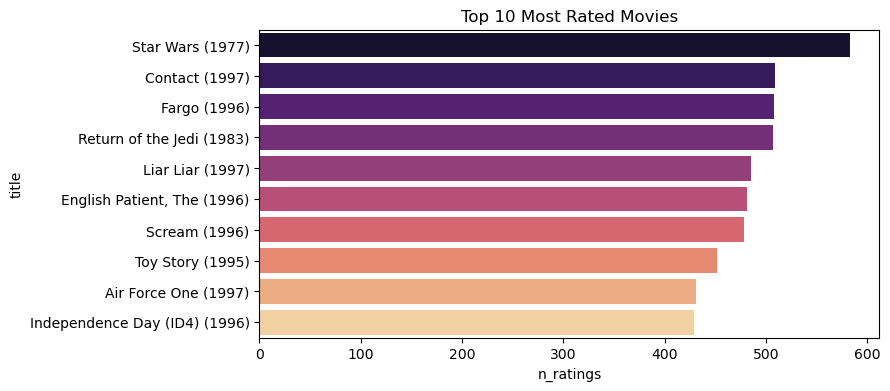

In [7]:
# ------------------------------
# 3. Top 10 most rated movies
# ------------------------------
most_rated = movie_stats.sort_values("n_ratings", ascending=False).head(10)
print("\nTop 10 Most Rated Movies:\n", most_rated)

plt.figure(figsize=(8,4))
sns.barplot(x="n_ratings", y="title", data=most_rated, palette="magma")
plt.title("Top 10 Most Rated Movies")
plt.show()


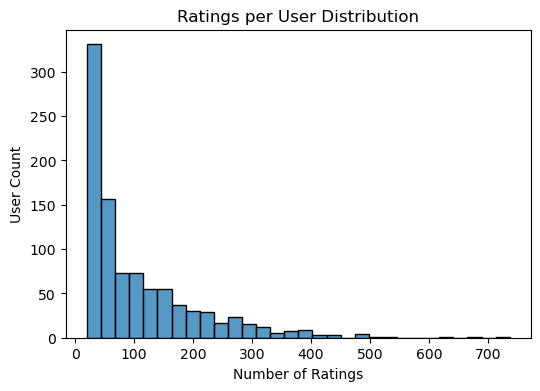

In [8]:
# ------------------------------
# 4. Ratings per user distribution
# ------------------------------
user_activity = data.groupby("user_id")["rating"].count()

plt.figure(figsize=(6,4))
sns.histplot(user_activity, bins=30, kde=False)
plt.title("Ratings per User Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("User Count")
plt.show()

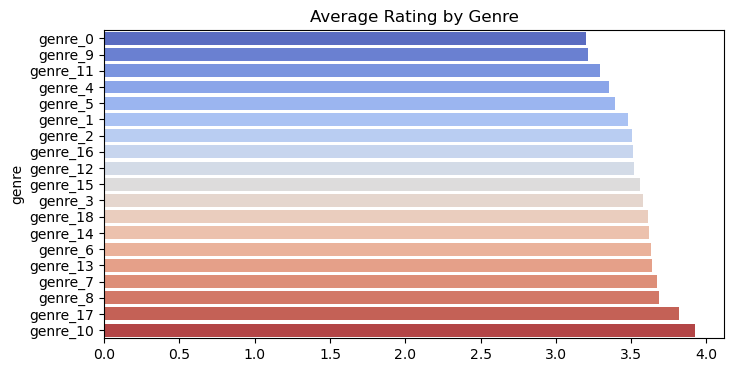

In [9]:
# ------------------------------
# 5. Avg rating by genre
# ------------------------------
# Extract genre columns
genre_cols = [c for c in movies.columns if "genre_" in c]
movie_genres = movies[["movie_id"] + genre_cols]

# Merge with ratings
genre_data = ratings.merge(movie_genres, on="movie_id")

# Melt to long format
genre_melt = genre_data.melt(
    id_vars=["rating"], 
    value_vars=genre_cols, 
    var_name="genre", 
    value_name="is_genre"
)

# Filter only rows where genre applies
genre_melt = genre_melt[genre_melt["is_genre"] == 1]

avg_rating_genre = genre_melt.groupby("genre")["rating"].mean().sort_values()

plt.figure(figsize=(8,4))
sns.barplot(x=avg_rating_genre.values, y=avg_rating_genre.index, palette="coolwarm")
plt.title("Average Rating by Genre")
plt.show()

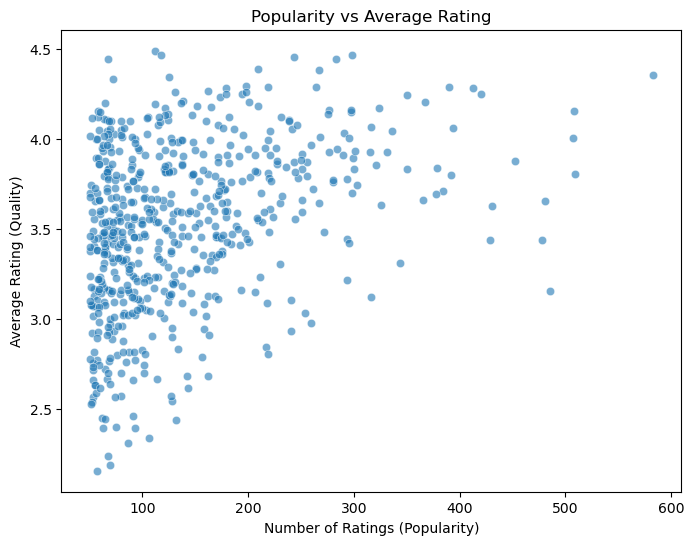

In [10]:
# ------------------------------
# 6. Popularity vs Quality scatterplot
# ------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x="n_ratings", y="avg_rating", data=filtered, alpha=0.6)
plt.title("Popularity vs Average Rating")
plt.xlabel("Number of Ratings (Popularity)")
plt.ylabel("Average Rating (Quality)")
plt.show()

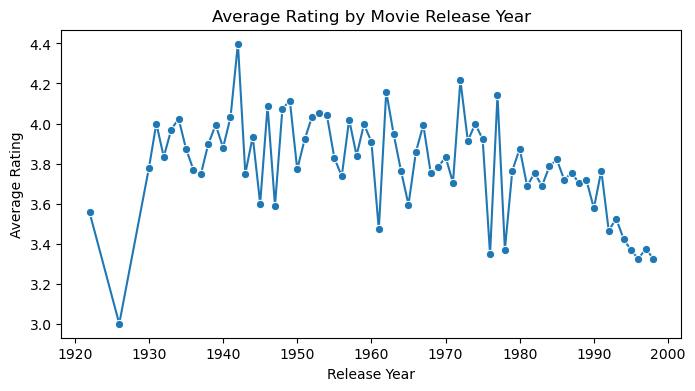

In [11]:
# ------------------------------
# 7. Average rating trend over release year
# ------------------------------
yearly = data.groupby("year")["rating"].mean().dropna()

plt.figure(figsize=(8,4))
sns.lineplot(x=yearly.index, y=yearly.values, marker="o")
plt.title("Average Rating by Movie Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.show()

### User Behavior & Demographics

In [12]:
# User demographics
users = pd.read_csv("ml-100k/u.user", sep="|", names=["user_id","age","gender","occupation","zip_code"])

# Merge ratings with user demographics
data = ratings.merge(users, on="user_id")

#### User Bias Analysis

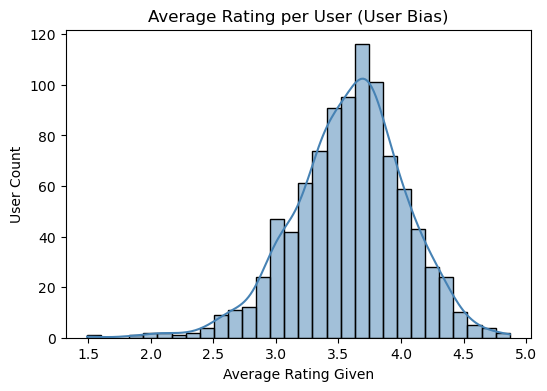

In [13]:
user_bias = data.groupby("user_id")["rating"].mean().reset_index()
plt.figure(figsize=(6,4))
sns.histplot(user_bias["rating"], bins=30, kde=True, color="steelblue")
plt.title("Average Rating per User (User Bias)")
plt.xlabel("Average Rating Given")
plt.ylabel("User Count")
plt.show()

#### Gender-Based Analysis

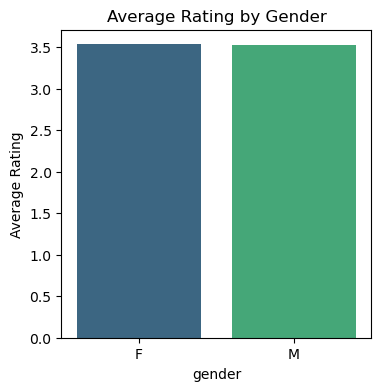

  gender    rating
0      F  3.531507
1      M  3.529289


In [14]:
gender_avg = data.groupby("gender")["rating"].mean().reset_index()

plt.figure(figsize=(4,4))
sns.barplot(x="gender", y="rating", data=gender_avg, palette="viridis")
plt.title("Average Rating by Gender")
plt.ylabel("Average Rating")
plt.show()

print(gender_avg)

#### Age Group Analysis

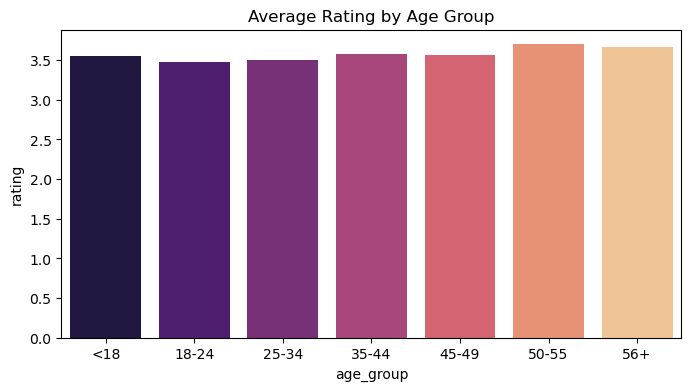

  age_group    rating
0       <18  3.552229
1     18-24  3.470565
2     25-34  3.497959
3     35-44  3.575259
4     45-49  3.567870
5     50-55  3.698416
6       56+  3.665577


In [15]:
bins = [0, 18, 25, 35, 45, 50, 56, 100]
labels = ["<18","18-24","25-34","35-44","45-49","50-55","56+"]
users["age_group"] = pd.cut(users["age"], bins=bins, labels=labels)

data = data.merge(users[["user_id","age_group"]], on="user_id")

age_avg = data.groupby("age_group")["rating"].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x="age_group", y="rating", data=age_avg, palette="magma")
plt.title("Average Rating by Age Group")
plt.show()

print(age_avg)

#### Occupation-Based Analysis

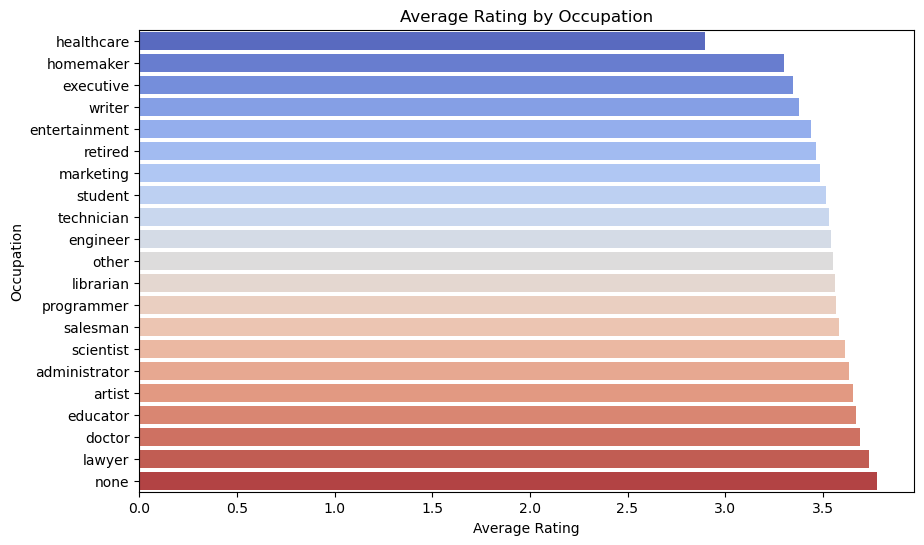

       occupation    rating
0      healthcare  2.896220
1       homemaker  3.301003
2       executive  3.349104
3          writer  3.375723
4   entertainment  3.441050
5         retired  3.466750
6       marketing  3.485641
7         student  3.515143
8      technician  3.532230
9        engineer  3.541407
10          other  3.552377
11      librarian  3.560781
12     programmer  3.568260
13       salesman  3.582944
14      scientist  3.611273
15  administrator  3.635646
16         artist  3.653380
17       educator  3.670621
18         doctor  3.688889
19         lawyer  3.735316
20           none  3.779134


In [16]:
occ_avg = data.groupby("occupation")["rating"].mean().sort_values().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="rating", y="occupation", data=occ_avg, palette="coolwarm")
plt.title("Average Rating by Occupation")
plt.xlabel("Average Rating")
plt.ylabel("Occupation")
plt.show()

print(occ_avg)

#### Polarizing Users Analysis

Most Polarizing Users:
      user_id      mean       var  count
608      609  2.392857  3.062169     28
761      762  3.047619  2.847619     21
530      531  3.233333  2.736782     30
67        68  3.029412  2.574866     34
37        38  3.719008  2.553719    121
178      179  3.047619  2.534262     42
218      219  3.714286  2.507937     28
173      174  3.581921  2.483308    177
198      199  2.950000  2.458974     40
738      739  3.600000  2.364706     35

Most Consistent Users:
      user_id      mean       var  count
848      849  4.869565  0.118577     23
354      355  4.076923  0.233846     26
476      477  4.457143  0.255462     35
468      469  4.534884  0.302326     43
32        33  3.708333  0.302536     24
551      552  3.095238  0.304073     84
766      767  4.432432  0.307808     37
383      384  4.136364  0.313853     22
887      888  4.300000  0.326316     20
9         10  4.206522  0.339629    184


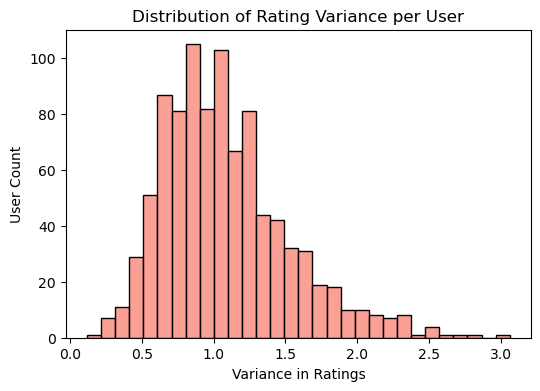

In [17]:
# Compute mean & variance of ratings per user
user_var = data.groupby("user_id")["rating"].agg(["mean", "var", "count"]).reset_index()
user_var = user_var[user_var["count"] >= 20]  # filter: only users with >=20 ratings to avoid noise

# Top 10 most polarizing (highest variance)
polarizing_users = user_var.sort_values("var", ascending=False).head(10)

# Top 10 most consistent (lowest variance)
consistent_users = user_var.sort_values("var", ascending=True).head(10)

print("Most Polarizing Users:\n", polarizing_users)
print("\nMost Consistent Users:\n", consistent_users)

# Visualize distribution of user variance
plt.figure(figsize=(6,4))
sns.histplot(user_var["var"], bins=30, kde=False, color="salmon")
plt.title("Distribution of Rating Variance per User")
plt.xlabel("Variance in Ratings")
plt.ylabel("User Count")
plt.show()

Polarizing users → people who rate both 1’s and 5’s (high variance).

Consistent users → people who stick to similar ratings (low variance).

Distribution plot → shows how common each type of user is.

#### Mean vs Variance per User

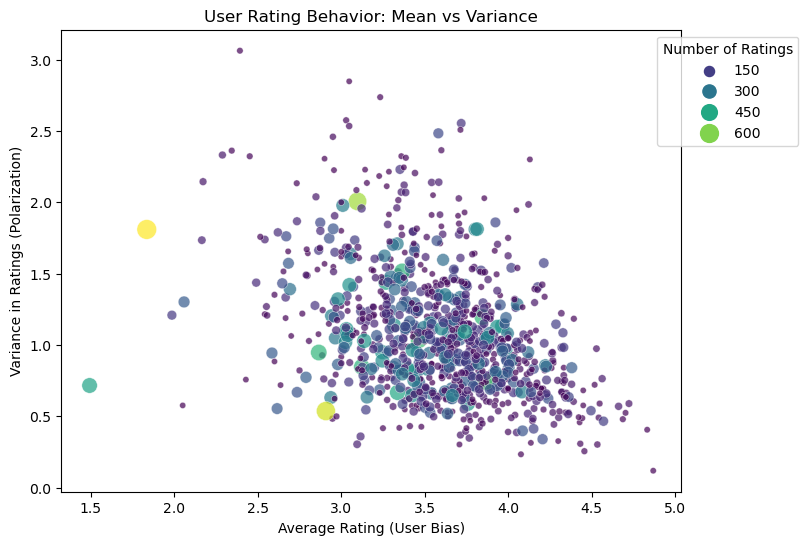

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="mean", 
    y="var", 
    size="count", 
    hue="count", 
    data=user_var, 
    palette="viridis", 
    alpha=0.7, 
    sizes=(20, 200)
)
plt.title("User Rating Behavior: Mean vs Variance")
plt.xlabel("Average Rating (User Bias)")
plt.ylabel("Variance in Ratings (Polarization)")
plt.legend(title="Number of Ratings", loc="upper right", bbox_to_anchor=(1.2,1))
plt.show()

X-axis (mean) → whether a user is generous (~4–5) or harsh (~1–2).

Y-axis (variance) → whether a user is consistent (low var) or polarizing (high var).

Point size/color → number of ratings by that user (so you can filter out one-offs).

So you’ll see clusters like:

Generous but consistent → always giving 4s.

Harsh but consistent → always giving 2s.

Polarizing → jumping between 1s and 5s.

🧑‍🤝‍🧑 User Behavior & Demographics Insights
1. User Bias (Average Rating per User)

Most users tend to cluster around an average rating of 3–4 stars, but we also see clear groups of “generous” users (avg >4) and “strict” users (avg <2.5). This highlights rating bias at the individual level.

2. Gender-Based Ratings

On average, male and female users rate movies similarly, with only minor differences. The distribution suggests that gender is not a strong differentiator in overall generosity of ratings.

3. Age Groups

Younger users (18–24) tend to be slightly more critical, while older groups (45+) give more generous ratings on average. This could indicate differences in expectations across age demographics.

4. Occupation

Some occupations appear to be “generous raters” (e.g., educators, retired users) while others (e.g., students, programmers) skew lower. This suggests lifestyle or cultural factors may influence how people score movies.

5. Polarizing Users

Looking at variance in ratings:

Polarizing users → rate both 1s and 5s, showing extreme swings.

Consistent users → stick to similar ratings across movies.

6. Mean vs Variance Scatterplot

The scatterplot of average rating vs variance reveals:

Generous but consistent users → always rate high (~4 stars, low variance).

Harsh but consistent users → stick to lower scores (~2 stars, low variance).

Polarizers → scatter across the plot, rating both high and low depending on the movie.

### Movie Similarity & Correlation

#### Correlation matrix of movies

In [22]:
# Merge ratings with movie titles
data = ratings.merge(movies[["movie_id","title"]], on="movie_id")

# Create user × movie matrix
user_movie_matrix = data.pivot_table(index="user_id", columns="title", values="rating")

# Compute correlation matrix (Pearson)
movie_corr = user_movie_matrix.corr(method='pearson', min_periods=20)  # min_periods=20 to avoid sparse correlations

In [23]:
# Example: Movies most correlated with "Star Wars (1977)"
target = "Star Wars (1977)"
similar_to_starwars = movie_corr[target].sort_values(ascending=False).head(10)
print(similar_to_starwars)

title
Star Wars (1977)                              1.000000
Empire Strikes Back, The (1980)               0.747981
Return of the Jedi (1983)                     0.672556
Meet John Doe (1941)                          0.633312
Ghost in the Shell (Kokaku kidotai) (1995)    0.599564
Raiders of the Lost Ark (1981)                0.536117
Night Falls on Manhattan (1997)               0.515291
When We Were Kings (1996)                     0.515164
Brassed Off (1996)                            0.515108
Some Folks Call It a Sling Blade (1993)       0.509016
Name: Star Wars (1977), dtype: float64


#### Genre Overlap

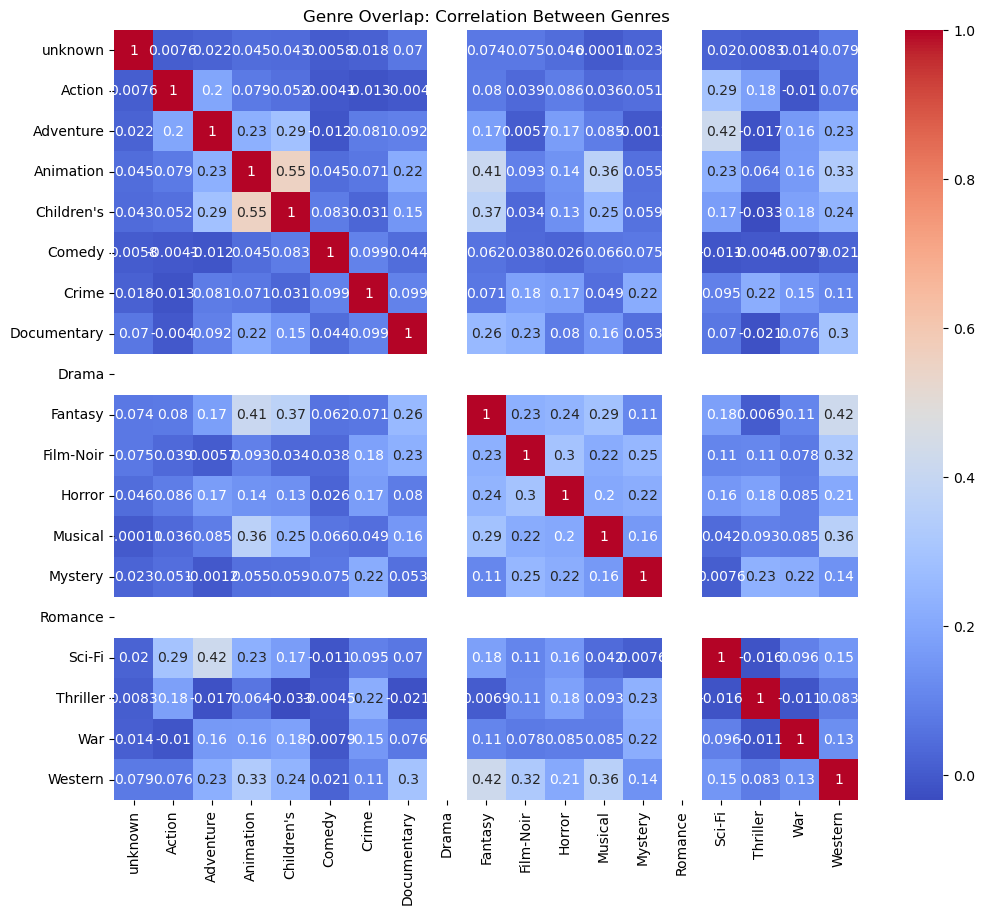

In [28]:
# Define genres mapping
genres = [
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

# Reload u.item with correct column names
movies = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None)
movies = movies.iloc[:, :24]
movies.columns = ["movie_id","title","release_date","video_release","imdb_url"] + genres

# Merge ratings with genre info
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id","movie_id","rating","timestamp"])
genre_ratings = ratings.merge(movies[["movie_id"] + genres], on="movie_id")

# Build user × genre preference matrix
user_genre = genre_ratings.groupby("user_id")[genres].max()

# Compute correlation between genres
genre_corr = user_genre.corr()

# Plot heatmap with proper genre labels
plt.figure(figsize=(12,10))
sns.heatmap(genre_corr, annot=True, cmap="coolwarm", xticklabels=genres, yticklabels=genres)
plt.title("Genre Overlap: Correlation Between Genres")
plt.show()

#### 1. Cluster movies based on correlation

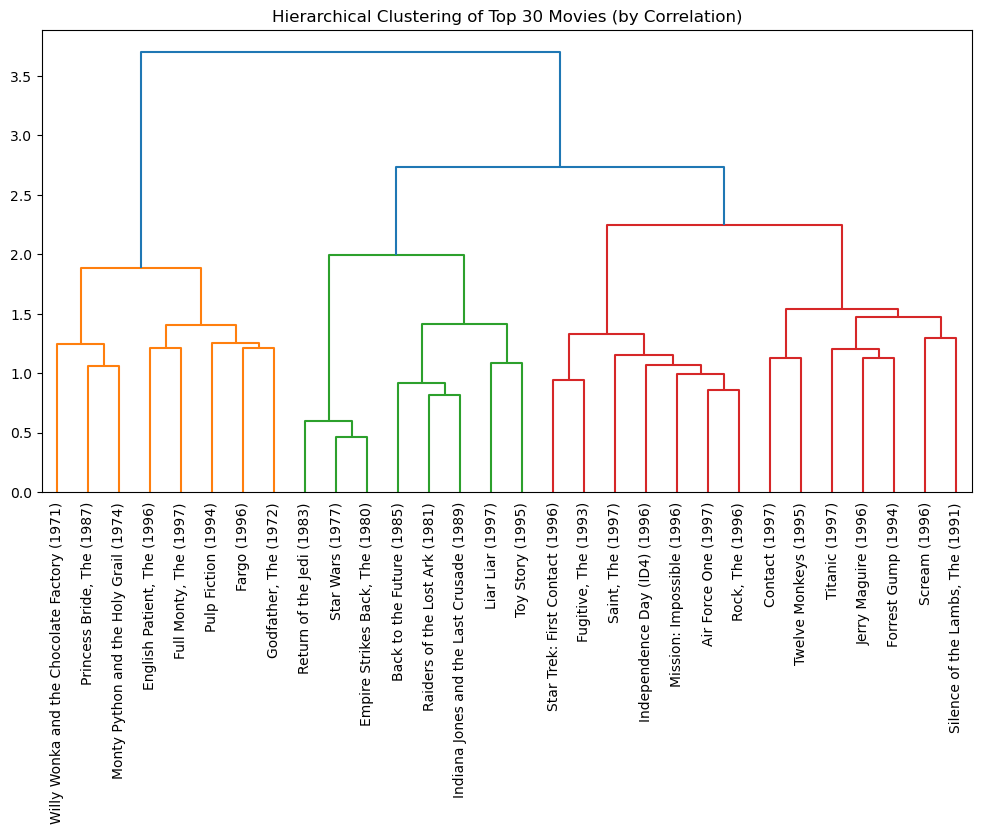

In [30]:
# Pivot user-movie matrix
user_movie_matrix = ratings.pivot_table(index="user_id", columns="movie_id", values="rating")

# Compute correlation between movies
movie_corr = user_movie_matrix.corr(min_periods=50)  # require at least 50 common raters

# Pick a sample of popular movies (to avoid overcrowding dendrogram)
top_movies = ratings["movie_id"].value_counts().head(30).index
corr_subset = movie_corr.loc[top_movies, top_movies]

# Hierarchical clustering
linked = linkage(corr_subset, method="ward")

plt.figure(figsize=(12,6))
dendrogram(linked, labels=[movies.set_index("movie_id").loc[mid,"title"] for mid in corr_subset.index], leaf_rotation=90)
plt.title("Hierarchical Clustering of Top 30 Movies (by Correlation)")
plt.show()

#### 2. Network graph of movie similarity

In [35]:
# Compute the correlation matrix (pairwise correlation between movies)
corr_matrix = user_movie_matrix.corr(min_periods=50)  # min_periods=50 avoids spurious correlations

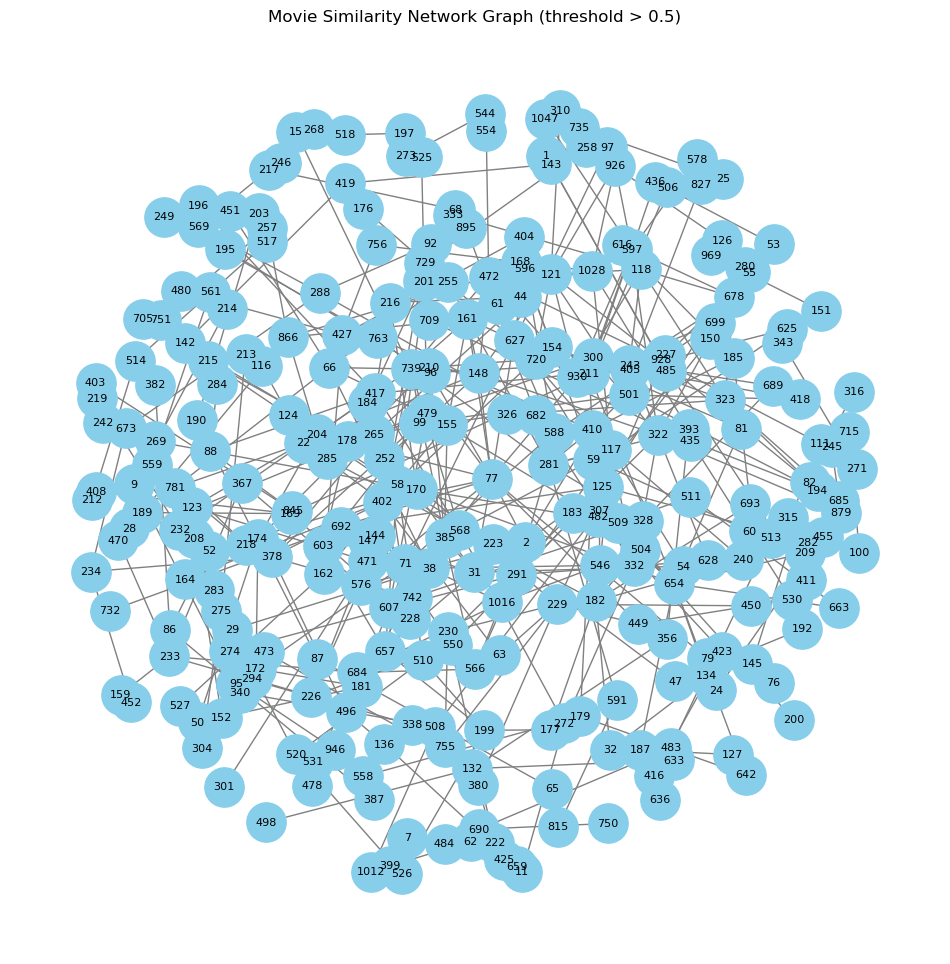

In [36]:
# Build the graph
G = nx.Graph()

# Add edges for correlations above threshold
threshold = 0.5
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if corr_matrix.iloc[i, j] > threshold:
            G.add_edge(corr_matrix.index[i], corr_matrix.index[j], weight=corr_matrix.iloc[i, j])

# Plot
fig, ax = plt.subplots(figsize=(12, 12))  # safer than plt.figure
pos = nx.spring_layout(G, k=0.3, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    font_size=8,
    node_color="skyblue",
    edge_color="gray",
    ax=ax   # explicitly use this axes
)

ax.set_title("Movie Similarity Network Graph (threshold > 0.5)")
plt.show()

#### 3. Weighted genre correlation

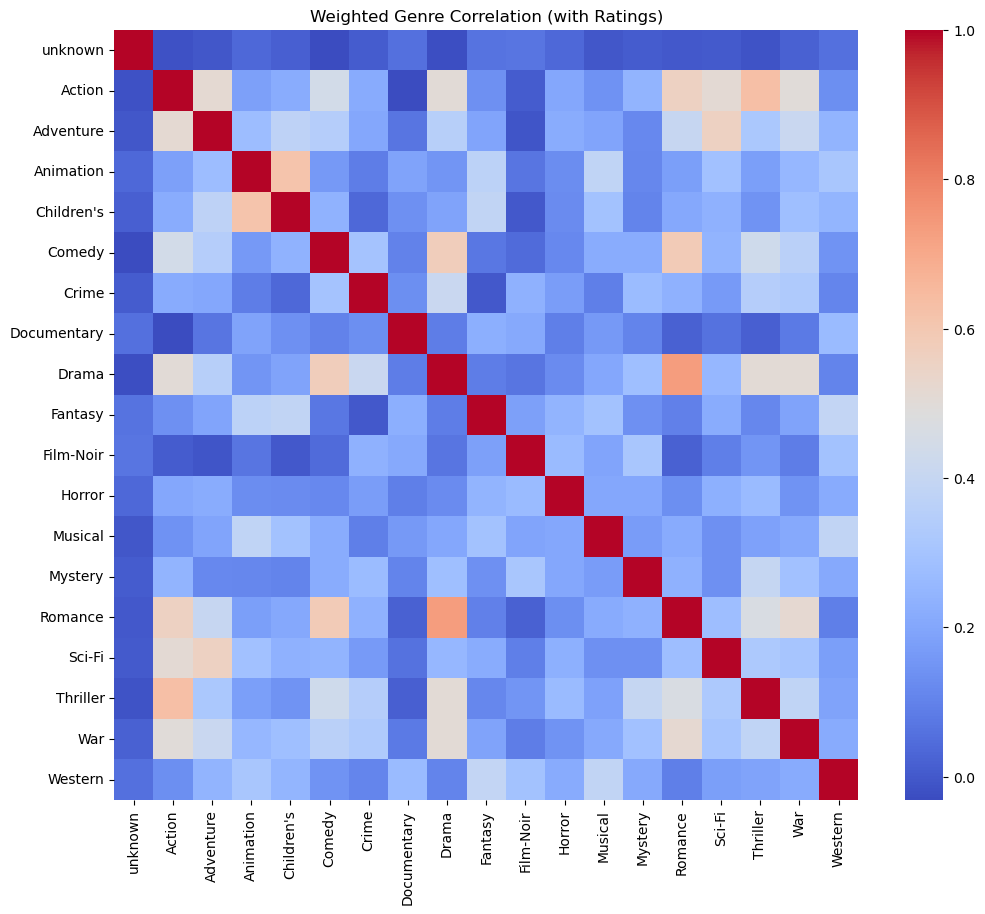

In [39]:
# Merge genres with ratings
genre_cols = [
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_full = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None)
movies_full = movies_full.iloc[:, :24]
movies_full.columns = ["movie_id","title","release_date","video_release","imdb_url"] + genre_cols

genre_ratings = ratings.merge(movies_full[["movie_id"] + genre_cols], on="movie_id")

# Compute average rating per genre per user (instead of binary)
weighted_genre = {}
for genre in genre_cols:
    weighted_genre[genre] = genre_ratings.groupby("user_id").apply(
        lambda x: (x["rating"] * x[genre]).sum() / max(1, x[genre].sum())
    )

user_genre_weighted = pd.DataFrame(weighted_genre)

# Correlation between genres (weighted by ratings)
genre_corr_weighted = user_genre_weighted.corr()

plt.figure(figsize=(12,10))
sns.heatmap(genre_corr_weighted, cmap="coolwarm", xticklabels=genre_cols, yticklabels=genre_cols)
plt.title("Weighted Genre Correlation (with Ratings)")
plt.show()

### Temporal Trends

#### User rating behavior over time

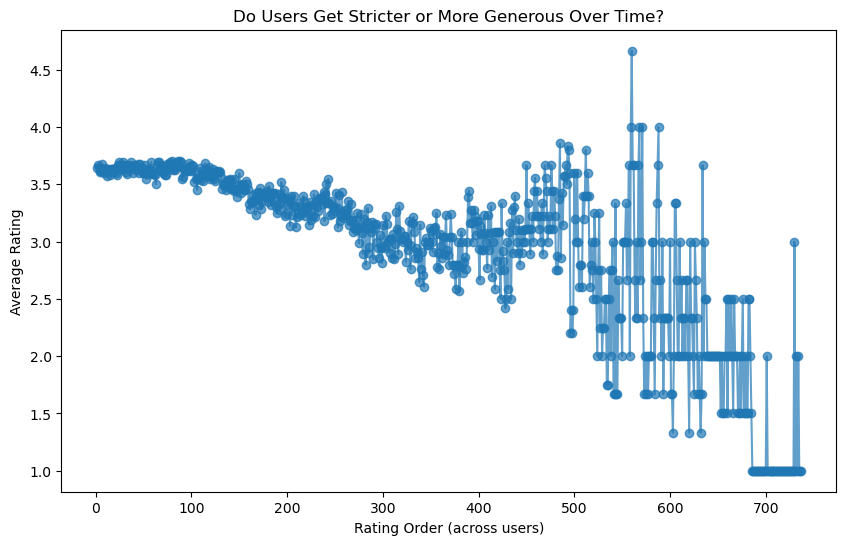

In [42]:
# Step 1: Sort ratings by time for each user
ratings_sorted = ratings.sort_values(by=["user_id", "timestamp"]).copy()

# Then add the order index:
ratings_sorted["rating_order"] = ratings_sorted.groupby("user_id").cumcount() + 1

# Step 3: Average rating by order index
avg_by_order = ratings_sorted.groupby("rating_order")["rating"].mean().reset_index()

# Step 4: Plot
plt.figure(figsize=(10,6))
plt.plot(avg_by_order["rating_order"], avg_by_order["rating"], marker="o", alpha=0.7)
plt.xlabel("Rating Order (across users)")
plt.ylabel("Average Rating")
plt.title("Do Users Get Stricter or More Generous Over Time?")
plt.show()

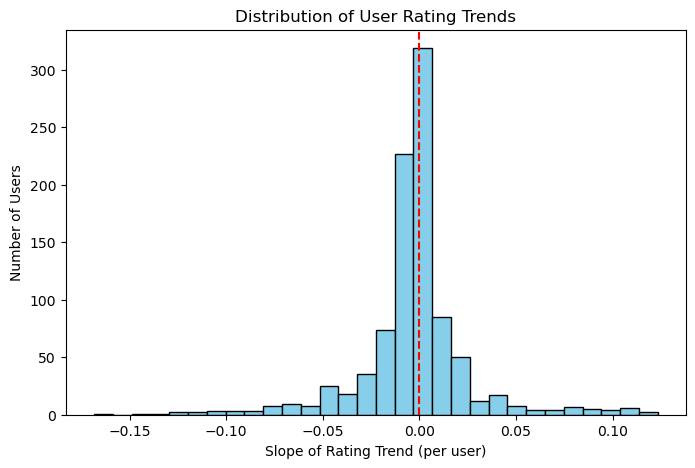

In [44]:
# Step 5: Fit slope per user
user_slopes = []
for uid, grp in ratings_sorted.groupby("user_id"):
    if len(grp) > 5:  # need enough ratings
        slope, intercept, r, p, se = linregress(grp["rating_order"], grp["rating"])
        user_slopes.append(slope)

# Distribution of slopes
plt.figure(figsize=(8,5))
plt.hist(user_slopes, bins=30, color="skyblue", edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Slope of Rating Trend (per user)")
plt.ylabel("Number of Users")
plt.title("Distribution of User Rating Trends")
plt.show()

#### Long-term popularity

/var/folders/mh/b599_8ps25b1bxtrz9p3zdvh0000gn/T/ipykernel_84746/2552478134.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



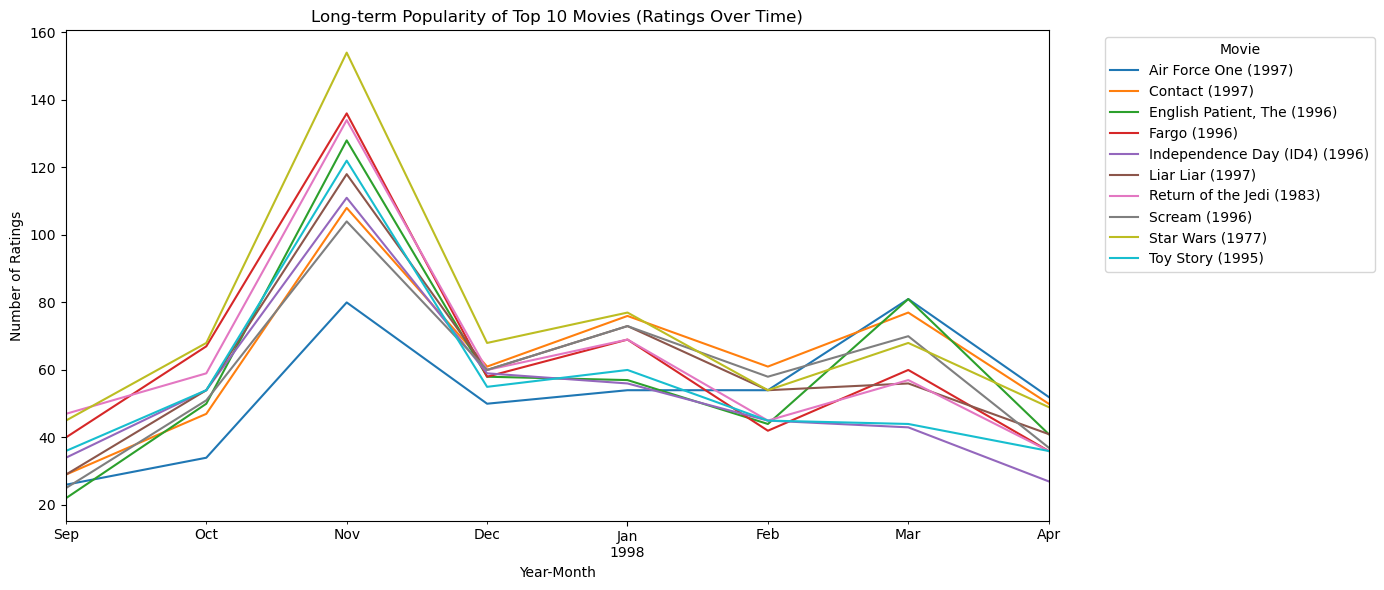

In [46]:
# Convert timestamp to datetime
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings["year_month"] = ratings["datetime"].dt.to_period("M")

# Count ratings per movie per month
movie_trends = ratings.groupby(["movie_id", "year_month"]).size().reset_index(name="num_ratings")

# Focus on popular movies (say, top 10 overall most rated)
top_movies = ratings["movie_id"].value_counts().head(10).index
movie_trends_top = movie_trends[movie_trends["movie_id"].isin(top_movies)]

# Map movie_id to title
movie_titles = movies.set_index("movie_id")["title"].to_dict()
movie_trends_top["title"] = movie_trends_top["movie_id"].map(movie_titles)

# Pivot for plotting
pivot_trends = movie_trends_top.pivot(index="year_month", columns="title", values="num_ratings").fillna(0)

# Plot
plt.figure(figsize=(14, 6))
pivot_trends.plot(ax=plt.gca())
plt.title("Long-term Popularity of Top 10 Movies (Ratings Over Time)")
plt.xlabel("Year-Month")
plt.ylabel("Number of Ratings")
plt.legend(title="Movie", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### Decay analysis

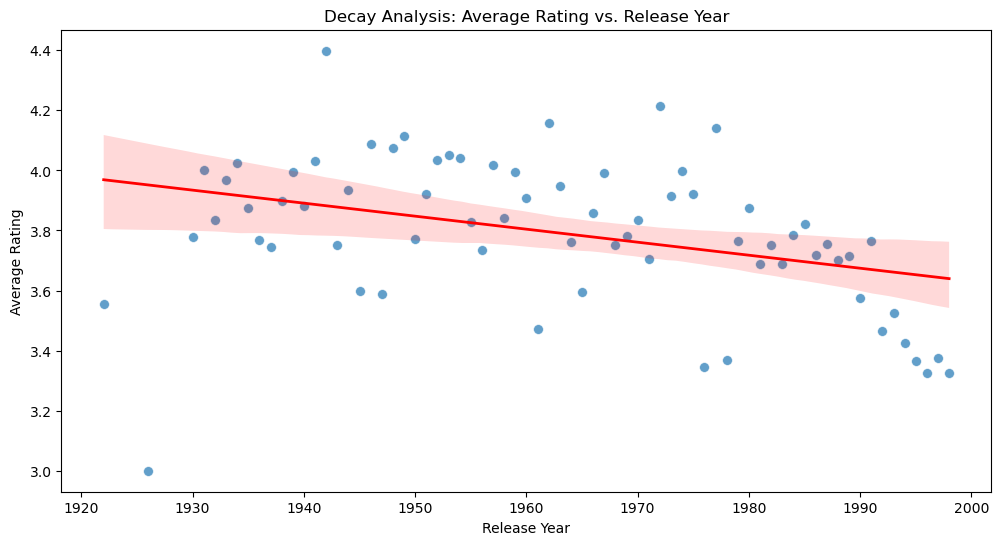

In [47]:
# Make sure movies has release year extracted
movies["release_year"] = movies["release_date"].str[-4:].astype(float)

# Merge ratings with movie release year
ratings_with_year = ratings.merge(movies[["movie_id", "release_year"]], on="movie_id", how="left")

# Group by release year and compute average rating
avg_rating_by_year = ratings_with_year.groupby("release_year")["rating"].mean().reset_index()

# Plot scatter + regression line
plt.figure(figsize=(12, 6))
sns.scatterplot(data=avg_rating_by_year, x="release_year", y="rating", s=50, alpha=0.7)
sns.regplot(data=avg_rating_by_year, x="release_year", y="rating", scatter=False, color="red", line_kws={"lw":2})

plt.title("Decay Analysis: Average Rating vs. Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.show()

In [48]:
# Optional: Compare grouped categories
ratings_with_year["era"] = pd.cut(
    ratings_with_year["release_year"],
    bins=[1900, 1970, 1990, 2000, 2010],
    labels=["Classic (<1970)", "Old School (70s-80s)", "90s", "2000s"]
)

era_means = ratings_with_year.groupby("era")["rating"].mean()
print("Average ratings by era:")
print(era_means)

Average ratings by era:
era
Classic (<1970)         3.925808
Old School (70s-80s)    3.766251
90s                     3.393428
2000s                        NaN
Name: rating, dtype: float64


### Cold-Start Analysis

#### The cold-start problem is a classic recommender systems issue: new movies (with few ratings) don’t have enough data to judge them compared to well-known ones.

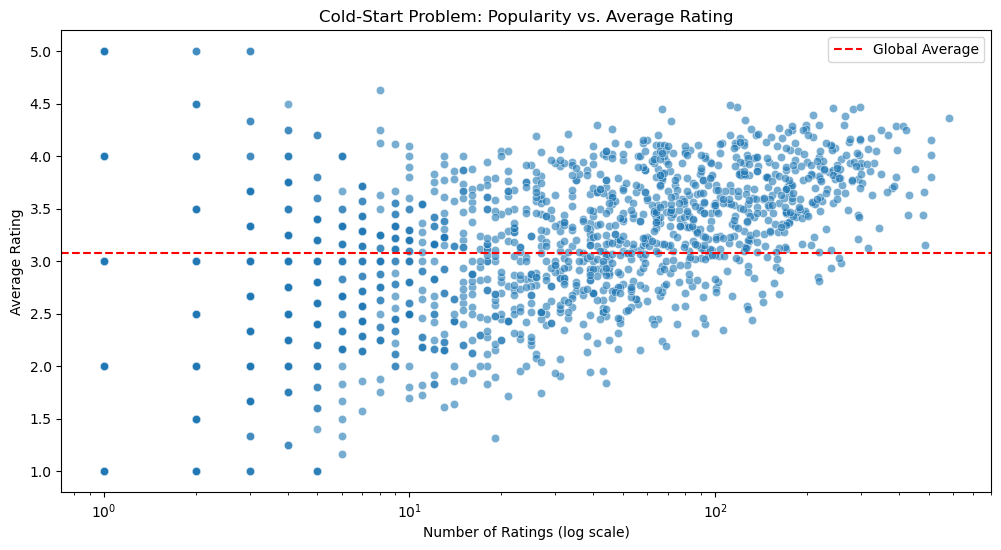

In [49]:
# Count number of ratings per movie
movie_stats = ratings.groupby("movie_id")["rating"].agg(["mean", "count"]).reset_index()
movie_stats = movie_stats.merge(movies[["movie_id", "title"]], on="movie_id", how="left")

# Plot: Number of ratings (popularity) vs average rating (quality)
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=movie_stats,
    x="count",
    y="mean",
    alpha=0.6
)

plt.axhline(movie_stats["mean"].mean(), color="red", linestyle="--", label="Global Average")
plt.xscale("log")  # ratings count often has long tail, log scale helps
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating")
plt.title("Cold-Start Problem: Popularity vs. Average Rating")
plt.legend()
plt.show()

Key Insights

Cold-start movies (far left, few ratings)

Their average ratings are highly scattered: some near 5, some near 1.

This volatility happens because just a handful of users can swing the average heavily.

Many of these look “over-rated” because usually only strong fans rate obscure or new movies.

Well-rated / Popular movies (far right, many ratings)

Ratings converge toward the global average (red dashed line).

With more user input, individual bias gets washed out, and the rating is more reliable.

Bias Pattern

Less popular movies tend to skew slightly higher than the global mean → early ratings often come from enthusiasts.

Popular movies cluster around 3–4 stars, showing balanced opinions as both critics and fans weigh in.

Recommender System Implication

Cold-start movies are hard to evaluate: a 4.7 with 3 ratings may not be as trustworthy as a 3.9 with 200 ratings.

Systems often use Bayesian averages / shrinkage to correct this: pulling small-sample averages toward the global mean until more data comes in.

In [50]:
# Optional: Define cold-start threshold
cold_start_threshold = 20
cold_movies = movie_stats[movie_stats["count"] < cold_start_threshold]
popular_movies = movie_stats[movie_stats["count"] >= cold_start_threshold]

print("Average rating of cold-start movies (<20 ratings):", cold_movies["mean"].mean())
print("Average rating of well-known movies (>=20 ratings):", popular_movies["mean"].mean())

Average rating of cold-start movies (<20 ratings): 2.7041326070629497
Average rating of well-known movies (>=20 ratings): 3.3703262363739928


#### Python code for Bayesian adjustment & scatterplots

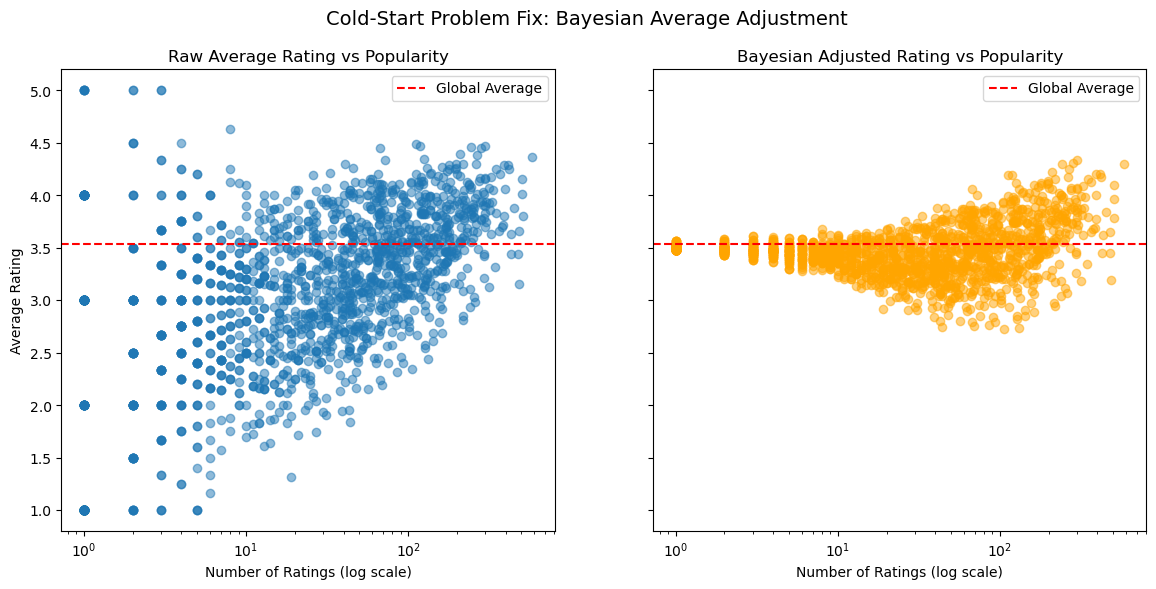

In [52]:
# Global average rating (C)
C = ratings["rating"].mean()

# Minimum votes threshold (m)
m = 50  

# Compute number of votes (v) and average rating (R) for each movie
movie_stats = ratings.groupby("movie_id").agg(
    v=("rating", "count"),
    R=("rating", "mean")
).reset_index()

# Bayesian Weighted Rating (WR)
movie_stats["WR"] = (
    (movie_stats["v"] / (movie_stats["v"] + m)) * movie_stats["R"]
    + (m / (movie_stats["v"] + m)) * C
)

# Plot before vs. after
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original Average Rating
axes[0].scatter(movie_stats["v"], movie_stats["R"], alpha=0.5)
axes[0].axhline(C, color="red", linestyle="--", label="Global Average")
axes[0].set_xscale("log")
axes[0].set_title("Raw Average Rating vs Popularity")
axes[0].set_xlabel("Number of Ratings (log scale)")
axes[0].set_ylabel("Average Rating")
axes[0].legend()

# Bayesian Adjusted Rating
axes[1].scatter(movie_stats["v"], movie_stats["WR"], alpha=0.5, color="orange")
axes[1].axhline(C, color="red", linestyle="--", label="Global Average")
axes[1].set_xscale("log")
axes[1].set_title("Bayesian Adjusted Rating vs Popularity")
axes[1].set_xlabel("Number of Ratings (log scale)")
axes[1].legend()

plt.suptitle("Cold-Start Problem Fix: Bayesian Average Adjustment", fontsize=14)
plt.show()

Before adjustment (left plot):

--> Movies with few ratings (left side) scatter wildly — some look like masterpieces (5.0) or disasters (1.0) based on very few votes.

--> Movies with many ratings converge around the global average (~3.5).

After adjustment (right plot):

--> Cold-start movies’ scores are shrunk toward the global mean, reducing noise.

--> Popular movies (large 𝑣) remain mostly unaffected.

The overall distribution looks tighter and fairer, which is why recommenders use Bayesian smoothing.

In [53]:
# Top movies by raw average rating (with min votes filter to avoid true noise)
min_votes_filter = 5
top_raw = (
    movie_stats[movie_stats["v"] >= min_votes_filter]
    .sort_values("R", ascending=False)
    .head(10)
)

# Top movies by Bayesian Weighted Rating
top_bayesian = (
    movie_stats[movie_stats["v"] >= min_votes_filter]
    .sort_values("WR", ascending=False)
    .head(10)
)

print("Top 10 Movies by Raw Average Rating:")
print(top_raw[["movie_id", "v", "R"]])

print("\nTop 10 Movies by Bayesian Adjusted Rating:")
print(top_bayesian[["movie_id", "v", "WR"]])

Top 10 Movies by Raw Average Rating:
      movie_id    v         R
1448      1449    8  4.625000
407        408  112  4.491071
317        318  298  4.466443
168        169  118  4.466102
482        483  243  4.456790
113        114   67  4.447761
63          64  283  4.445230
602        603  209  4.387560
11          12  267  4.385768
49          50  583  4.358491

Top 10 Movies by Bayesian Adjusted Rating:
     movie_id    v        WR
317       318  298  4.331876
63         64  283  4.307787
482       483  243  4.298611
49         50  583  4.293038
11         12  267  4.250767
602       603  209  4.221981
97         98  390  4.203393
126       127  413  4.201929
407       408  112  4.194401
168       169  118  4.187458


In [56]:
print(movies.columns)

Index(['movie_id', 'title', 'release_date', 'video_release', 'imdb_url',
       'unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'release_year'],
      dtype='object')


In [57]:
# Join with correct key (movie_id)
movie_stats_named = movie_stats.merge(
    movies[["movie_id", "title"]],
    on="movie_id",
    how="left"
)

# Top 10 by raw average rating
min_votes_filter = 5
top_raw = (
    movie_stats_named[movie_stats_named["v"] >= min_votes_filter]
    .sort_values("R", ascending=False)
    .head(10)
)

# Top 10 by Bayesian Weighted Rating
top_bayesian = (
    movie_stats_named[movie_stats_named["v"] >= min_votes_filter]
    .sort_values("WR", ascending=False)
    .head(10)
)

print("Top 10 Movies by Raw Average Rating:")
print(top_raw[["title", "v", "R"]])

print("\nTop 10 Movies by Bayesian Adjusted Rating:")
print(top_bayesian[["title", "v", "WR"]])


Top 10 Movies by Raw Average Rating:
                                                  title    v         R
1448                             Pather Panchali (1955)    8  4.625000
407                               Close Shave, A (1995)  112  4.491071
317                             Schindler's List (1993)  298  4.466443
168                          Wrong Trousers, The (1993)  118  4.466102
482                                   Casablanca (1942)  243  4.456790
113   Wallace & Gromit: The Best of Aardman Animatio...   67  4.447761
63                     Shawshank Redemption, The (1994)  283  4.445230
602                                  Rear Window (1954)  209  4.387560
11                           Usual Suspects, The (1995)  267  4.385768
49                                     Star Wars (1977)  583  4.358491

Top 10 Movies by Bayesian Adjusted Rating:
                                title    v        WR
317           Schindler's List (1993)  298  4.331876
63   Shawshank Redemption, The (

#### Rating variance per movie:

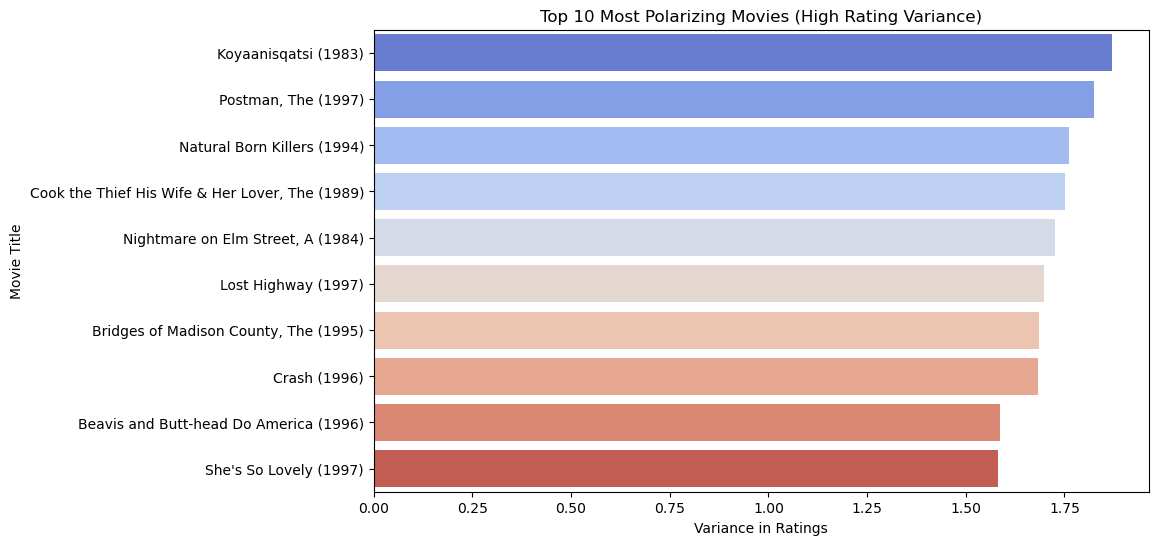

In [58]:
# Compute variance of ratings per movie
variance_stats = ratings.groupby("movie_id")["rating"].agg(["mean", "var", "count"]).reset_index()

# Join with titles
variance_stats = variance_stats.merge(
    movies[["movie_id", "title"]],
    on="movie_id",
    how="left"
)

# Filter movies with enough ratings (to avoid noise)
min_ratings = 50
polarizing = variance_stats[variance_stats["count"] >= min_ratings].sort_values("var", ascending=False)

# Top 10 most polarizing movies
top_polarizing = polarizing.head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_polarizing,
    x="var",
    y="title",
    palette="coolwarm"
)
plt.xlabel("Variance in Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Most Polarizing Movies (High Rating Variance)")
plt.show()

🔎 Insights from the plot

Cult classics & art films dominate

Koyaanisqatsi (1983) and Cook the Thief His Wife & Her Lover (1989) are experimental/art-house films. These tend to be adored by some for their boldness but confusing or boring for others → high variance.

Blockbusters that didn’t land evenly

The Postman (1997) and Natural Born Killers (1994) are polarizing mainstream movies. The Postman was critically panned but has defenders; Natural Born Killers is violent, satirical, and divisive.

Cult horror & edgy themes

Nightmare on Elm Street (1984) and Lost Highway (1997) represent genres that naturally split audiences — horror and surreal Lynch-style cinema.

Romance & melodrama split tastes

The Bridges of Madison County (1995) and She’s So Lovely (1997) fall into drama/romance territory. These genres often divide audiences depending on patience for slower, emotional storytelling.

Comedy that isn’t universal

Beavis and Butt-head Do America (1996) shows that lowbrow humor isn’t for everyone — some love it, others rate it bottom-barrel.

“Crash” (1996)

Another provocative entry with dark, disturbing themes. It’s a textbook polarizing movie — you either see brilliance or nonsense.

💡 What this tells you about movie data:

Movies with high variance are often genre-pushing, controversial, or cultish.

These are “love-it-or-hate-it” films, which are the trickiest to recommend in systems like Netflix — you need personalization, not popularity alone.

By contrast, universally loved movies (low variance + high mean) tend to be safe family blockbusters or classics.

#### Genre rating variance: Which genres are most controversial?

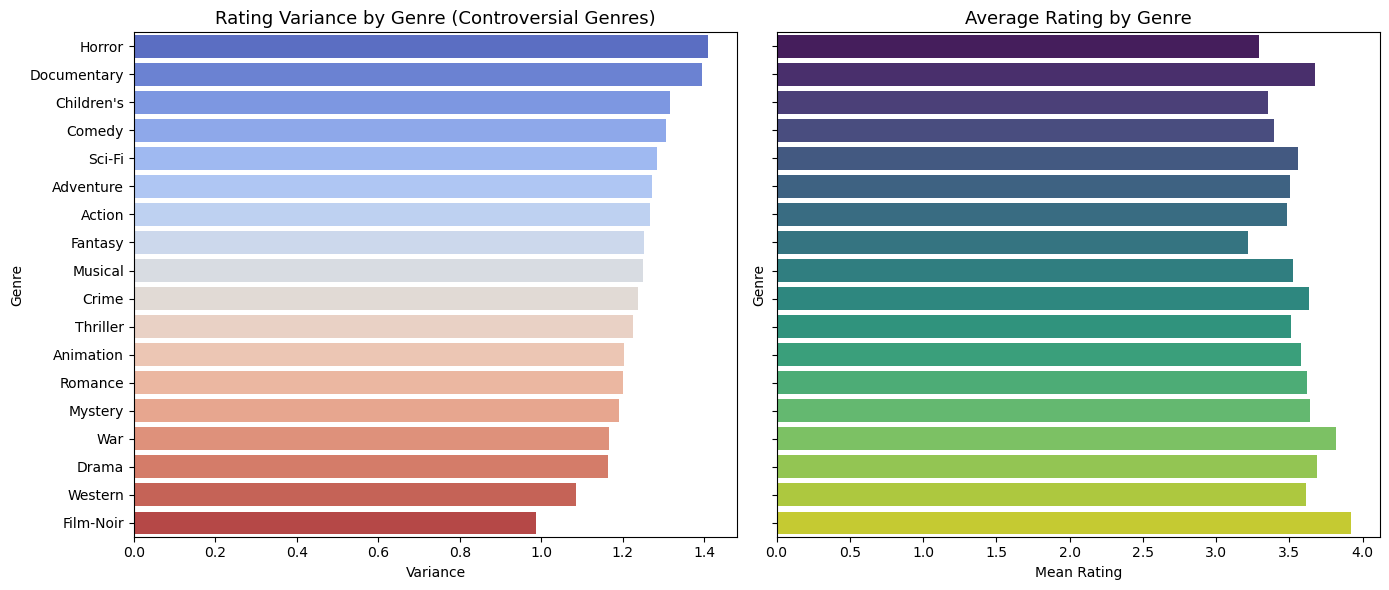

In [60]:
# Define genre columns based on your dataset
genre_cols = ['Action','Adventure','Animation',"Children's",'Comedy',
              'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
              'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

# Reshape to long format → one row per (rating, genre)
genre_ratings = df.melt(
    id_vars=['rating'], 
    value_vars=genre_cols, 
    var_name='Genre', 
    value_name='is_genre'
)

# Keep only rows where genre applies
genre_ratings = genre_ratings[genre_ratings['is_genre'] == 1]

# Compute both variance and mean rating per genre
genre_stats = genre_ratings.groupby('Genre')['rating'].agg(['var', 'mean']).reset_index()
genre_stats = genre_stats.sort_values(by='var', ascending=False)

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Variance
sns.barplot(data=genre_stats, x='var', y='Genre', ax=axes[0], palette='coolwarm')
axes[0].set_title("Rating Variance by Genre (Controversial Genres)", fontsize=13)
axes[0].set_xlabel("Variance")

# Mean rating
sns.barplot(data=genre_stats, x='mean', y='Genre', ax=axes[1], palette='viridis')
axes[1].set_title("Average Rating by Genre", fontsize=13)
axes[1].set_xlabel("Mean Rating")

plt.tight_layout()
plt.show()

### Recommender System Foundations

#### User–user similarity: Find “nearest neighbors” in rating style.

In [61]:
from sklearn.metrics.pairwise import cosine_similarity

# Pivot ratings into user-item matrix (users as rows, movies as columns)
user_item_matrix = df.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating'
)

# Fill NaN with 0 (unrated movies treated as 0 for similarity calculation)
user_item_filled = user_item_matrix.fillna(0)

# Compute cosine similarity between users
user_sim = cosine_similarity(user_item_filled)

# Put into a DataFrame for easier inspection
user_sim_df = pd.DataFrame(
    user_sim, 
    index=user_item_filled.index, 
    columns=user_item_filled.index
)

# Example: find top-5 most similar users to a given user
target_user = 42  # can be whatever i like
nearest_neighbors = (
    user_sim_df[target_user]
    .drop(target_user)   # remove self
    .sort_values(ascending=False)
    .head(5)
)

print(f"Top-5 nearest neighbors for User {target_user}:")
print(nearest_neighbors)

Top-5 nearest neighbors for User 42:
user_id
577    0.563767
864    0.563222
311    0.559130
618    0.547701
290    0.547329
Name: 42, dtype: float64


#### finding neighbors → to recommending movies.

In [63]:
import numpy as np

def recommend_movies_for_user(target_user, user_item_matrix, user_sim_df, top_n_neighbors=5, top_k_recs=10):
    """
    Recommend movies to a target user based on nearest neighbors.
    """
    # 1. Find nearest neighbors
    neighbors = (
        user_sim_df[target_user]
        .drop(target_user)
        .sort_values(ascending=False)
        .head(top_n_neighbors)
    )

    # 2. Get movies the target user has already rated
    user_rated = user_item_matrix.loc[target_user].dropna().index

    # 3. Weighted ratings from neighbors (similarity as weight)
    weighted_scores = np.zeros(user_item_matrix.shape[1])
    similarity_sums = np.zeros(user_item_matrix.shape[1])

    for neighbor, sim in neighbors.items():
        neighbor_ratings = user_item_matrix.loc[neighbor].fillna(0).values
        weighted_scores += sim * neighbor_ratings
        similarity_sums += sim * (neighbor_ratings > 0)  # count only rated items

    # Avoid division by zero
    scores = weighted_scores / (similarity_sums + 1e-9)

    # 4. Build recommendations DataFrame
    recs = pd.DataFrame({
        'movie_id': user_item_matrix.columns,
        'score': scores
    })

    # Remove already-rated movies
    recs = recs[~recs['movie_id'].isin(user_rated)]

    # Top-K recommendations
    top_recs = recs.sort_values(by="score", ascending=False).head(top_k_recs)

    return top_recs

# Example usage
top_recommendations = recommend_movies_for_user(
    target_user=42, 
    user_item_matrix=user_item_matrix, 
    user_sim_df=user_sim_df, 
    top_n_neighbors=5, 
    top_k_recs=10
)

# Merge with movie names for readability
top_recommendations_named = top_recommendations.merge(
    movies[['movie_id', 'title']], 
    on='movie_id', 
    how='left'
)

print(top_recommendations_named)

   movie_id  score                                              title
0       134    5.0                                Citizen Kane (1941)
1       727    5.0                            Immortal Beloved (1994)
2       223    5.0                                 Sling Blade (1996)
3       333    5.0                                   Game, The (1997)
4       114    5.0  Wallace & Gromit: The Best of Aardman Animatio...
5       328    5.0                           Conspiracy Theory (1997)
6       169    5.0                         Wrong Trousers, The (1993)
7       408    5.0                              Close Shave, A (1995)
8       201    5.0                                Evil Dead II (1987)
9       343    5.0                         Alien: Resurrection (1997)


#### Item–item similarity (often more stable in practice).

In [65]:
# 1. Compute item–item similarity matrix
item_sim = user_item_matrix.T.corr(method='pearson')  # movies × movies similarity

# 2. Function to recommend similar movies
def recommend_similar_movies(movie_title, item_sim, movies, top_k=10):
    """
    Given a movie title, recommend similar movies based on item–item similarity.
    """
    # Find movie_id for the given title
    movie_id_row = movies[movies['title'].str.contains(movie_title, case=False, regex=False)]
    if movie_id_row.empty:
        return f"Movie '{movie_title}' not found."
    movie_id = movie_id_row['movie_id'].values[0]

    # Get similarity scores for that movie
    sim_scores = item_sim[movie_id].drop(labels=[movie_id])  # drop self
    sim_scores = sim_scores.sort_values(ascending=False).head(top_k)

    # Merge with movie titles for readability
    recs = sim_scores.reset_index()
    recs.columns = ['movie_id', 'similarity']
    recs = recs.merge(movies[['movie_id', 'title']], on='movie_id', how='left')

    return recs[['title', 'similarity']]

# Example usage
recommendations = recommend_similar_movies("Star Wars (1977)", item_sim, movies, top_k=10)
print(recommendations)

                          title  similarity
0  Bride of Frankenstein (1935)         1.0
1                 Girl 6 (1996)         1.0
2       Harold and Maude (1971)         1.0
3          Graduate, The (1967)         1.0
4  Browning Version, The (1994)         1.0
5             Persuasion (1995)         1.0
6     This Is Spinal Tap (1984)         1.0
7                      M (1931)         1.0
8                  Andre (1994)         1.0
9              Boot, Das (1981)         1.0


#### output doesnt look good

In [66]:
from scipy.stats import pearsonr

def compute_item_similarity(user_item_matrix, min_overlap=5):
    """
    Compute item–item similarity with Pearson correlation,
    requiring at least `min_overlap` users in common.
    """
    item_sim = pd.DataFrame(index=user_item_matrix.columns, columns=user_item_matrix.columns, dtype=float)

    for i, m1 in enumerate(user_item_matrix.columns):
        for j, m2 in enumerate(user_item_matrix.columns):
            if i >= j:  # avoid duplicate work
                continue
            # Drop NaNs to find common raters
            common = user_item_matrix[[m1, m2]].dropna()
            if len(common) >= min_overlap:
                corr, _ = pearsonr(common[m1], common[m2])
                item_sim.loc[m1, m2] = corr
                item_sim.loc[m2, m1] = corr

    return item_sim

# Recompute with minimum 5 common raters
item_sim = compute_item_similarity(user_item_matrix, min_overlap=5)

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/asimjamal/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424

In [67]:
recommendations = recommend_similar_movies("Star Wars (1977)", item_sim, movies, top_k=10)
print(recommendations)

                             title  similarity
0           Man of the Year (1995)    1.000000
1     Love in the Afternoon (1957)    0.923381
2        'Til There Was You (1997)    0.872872
3            A Chef in Love (1996)    0.868599
4     Dream With the Fishes (1997)    0.804084
5             Paradise Road (1997)    0.790569
6          Unhook the Stars (1996)    0.771744
7                     Bliss (1997)    0.750000
8          That Old Feeling (1997)    0.750000
9  Empire Strikes Back, The (1980)    0.747981


#### good progress now lets impriove this better

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_item_similarity(ratings):
    """
    Compute item–item cosine similarity and overlap counts.

    Parameters:
        ratings (DataFrame): user–item ratings matrix (rows = users, cols = movies).

    Returns:
        item_sim (DataFrame): Item–item similarity matrix.
        item_overlap (DataFrame): Number of common raters for each item pair.
    """
    # Convert to user–item matrix (fill unrated with 0)
    user_item = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

    # Binary mask (1 if rated, else 0)
    rated_mask = (user_item > 0).astype(int)

    # Cosine similarity
    sim_matrix = cosine_similarity(user_item.T)  # transpose so items are compared
    item_sim = pd.DataFrame(sim_matrix, 
                            index=user_item.columns, 
                            columns=user_item.columns)

    # Overlap = dot product of rated_mask
    overlap_matrix = rated_mask.T.dot(rated_mask)
    item_overlap = pd.DataFrame(overlap_matrix, 
                                index=user_item.columns, 
                                columns=user_item.columns)

    return item_sim, item_overlap


In [71]:
# Recompute similarity + overlap
item_sim, item_overlap = compute_item_similarity(ratings)

# Now call recommender
recommendations = recommend_similar_movies(
    "Star Wars (1977)", item_sim, movies, top_k=10, min_overlap=50, damping=50
)
print(recommendations)

                                       title  similarity  overlap
0                           Star Wars (1977)    0.921011      583
1                  Return of the Jedi (1983)    0.801035      480
2             Raiders of the Lost Ark (1981)    0.675945      380
3            Empire Strikes Back, The (1980)    0.654905      345
4                           Toy Story (1995)    0.649355      381
5                      Godfather, The (1972)    0.611665      357
6                               Fargo (1996)    0.609220      394
7              Independence Day (ID4) (1996)    0.608755      362
8  Indiana Jones and the Last Crusade (1989)    0.591978      304
9           Silence of the Lambs, The (1991)    0.588581      335


#### Add caching --> recompute similarity & overlap every time we rerun recommendations

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

# Global caches
_item_sim = None
_item_overlap = None

def compute_item_similarity(ratings, force_recompute=False):
    """
    Compute and cache item–item cosine similarity and overlap counts.

    Parameters:
        ratings (DataFrame): user–item ratings matrix (rows = users, cols = movies).
        force_recompute (bool): if True, recompute even if cache exists.

    Returns:
        item_sim (DataFrame): Item–item similarity matrix.
        item_overlap (DataFrame): Number of common raters for each item pair.
    """
    global _item_sim, _item_overlap

    if _item_sim is not None and _item_overlap is not None and not force_recompute:
        return _item_sim, _item_overlap

    # Convert to user–item matrix (fill unrated with 0)
    user_item = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

    # Binary mask (1 if rated, else 0)
    rated_mask = (user_item > 0).astype(int)

    # Cosine similarity
    sim_matrix = cosine_similarity(user_item.T)
    _item_sim = pd.DataFrame(sim_matrix, 
                             index=user_item.columns, 
                             columns=user_item.columns)

    # Overlap = dot product of rated_mask
    overlap_matrix = rated_mask.T.dot(rated_mask)
    _item_overlap = pd.DataFrame(overlap_matrix, 
                                 index=user_item.columns, 
                                 columns=user_item.columns)

    return _item_sim, _item_overlap


def recommend_similar_movies(movie_title, movies, top_k=10, min_overlap=50, damping=50):
    """
    Recommend similar movies based on item–item similarity.
    Uses cached similarity & overlap if available.

    Parameters:
        movie_title (str): Title of the reference movie.
        movies (DataFrame): Movie metadata with [movie_id, title].
        top_k (int): Number of recommendations.
        min_overlap (int): Minimum number of common raters to consider.
        damping (int): Damping factor to penalize low-overlap similarities.

    Returns:
        DataFrame: Top recommended movies with similarity scores.
    """
    global _item_sim, _item_overlap
    if _item_sim is None or _item_overlap is None:
        raise ValueError("Run compute_item_similarity(ratings) first before recommending.")

    # Lookup movie_id
    movie_id = movies.loc[movies['title'] == movie_title, 'movie_id'].values
    if len(movie_id) == 0:
        raise ValueError(f"Movie '{movie_title}' not found in dataset.")
    movie_id = movie_id[0]

    # Similarities and overlaps
    sim_scores = _item_sim[movie_id].drop(movie_id)  # drop itself
    overlaps = _item_overlap[movie_id].reindex(sim_scores.index)

    # Filter by minimum overlap
    mask = overlaps >= min_overlap
    sim_scores = sim_scores[mask]
    overlaps = overlaps[mask]

    # Apply damping: weighted similarity = sim * (overlap / (overlap + damping))
    weighted_scores = sim_scores * (overlaps / (overlaps + damping))

    # Sort top-k
    recs = weighted_scores.sort_values(ascending=False).head(top_k).reset_index()
    recs = recs.merge(movies[['movie_id', 'title']], on='movie_id', how='left')

    return recs[['title', movie_id]].rename(columns={movie_id: 'similarity'})

In [73]:
# Step 1: Compute once (cached globally)
item_sim, item_overlap = compute_item_similarity(ratings)

# Step 2: Get recommendations instantly (no recompute)
recommendations = recommend_similar_movies(
    "Star Wars (1977)", movies, top_k=10, min_overlap=50, damping=50
)
print(recommendations)

                                       title  similarity
0                  Return of the Jedi (1983)    0.801035
1             Raiders of the Lost Ark (1981)    0.675945
2            Empire Strikes Back, The (1980)    0.654905
3                           Toy Story (1995)    0.649355
4                      Godfather, The (1972)    0.611665
5                               Fargo (1996)    0.609220
6              Independence Day (ID4) (1996)    0.608755
7  Indiana Jones and the Last Crusade (1989)    0.591978
8           Silence of the Lambs, The (1991)    0.588581
9            Star Trek: First Contact (1996)    0.581902


#### option to save the cached similarity/overlap to disk

In [74]:
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# Global caches
_item_sim = None
_item_overlap = None
CACHE_FILE = "item_similarity_cache.pkl"

def compute_item_similarity(ratings, cache_file=CACHE_FILE, force_recompute=False):
    """
    Compute and cache item–item cosine similarity and overlap counts.
    Saves results to disk for reuse across sessions.

    Parameters:
        ratings (DataFrame): user–item ratings matrix (rows = users, cols = movies).
        cache_file (str): Path to pickle file for saving/loading cache.
        force_recompute (bool): If True, recompute even if cache exists.

    Returns:
        item_sim (DataFrame): Item–item similarity matrix.
        item_overlap (DataFrame): Number of common raters for each item pair.
    """
    global _item_sim, _item_overlap

    # Load cache from disk if available
    if not force_recompute and os.path.exists(cache_file):
        with open(cache_file, "rb") as f:
            _item_sim, _item_overlap = pickle.load(f)
        print(f"Loaded cached similarity & overlap from {cache_file}")
        return _item_sim, _item_overlap

    # Otherwise compute from scratch
    user_item = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    rated_mask = (user_item > 0).astype(int)

    # Cosine similarity
    sim_matrix = cosine_similarity(user_item.T)
    _item_sim = pd.DataFrame(sim_matrix, 
                             index=user_item.columns, 
                             columns=user_item.columns)

    # Overlap (number of common raters)
    overlap_matrix = rated_mask.T.dot(rated_mask)
    _item_overlap = pd.DataFrame(overlap_matrix, 
                                 index=user_item.columns, 
                                 columns=user_item.columns)

    # Save to cache
    with open(cache_file, "wb") as f:
        pickle.dump((_item_sim, _item_overlap), f)
    print(f"Computed and cached similarity & overlap to {cache_file}")

    return _item_sim, _item_overlap


def recommend_similar_movies(movie_title, movies, top_k=10, min_overlap=50, damping=50):
    """
    Recommend similar movies based on item–item similarity.
    Uses cached similarity & overlap if available.

    Parameters:
        movie_title (str): Title of the reference movie.
        movies (DataFrame): Movie metadata with [movie_id, title].
        top_k (int): Number of recommendations.
        min_overlap (int): Minimum number of common raters to consider.
        damping (int): Damping factor to penalize low-overlap similarities.

    Returns:
        DataFrame: Top recommended movies with similarity scores.
    """
    global _item_sim, _item_overlap
    if _item_sim is None or _item_overlap is None:
        raise ValueError("Run compute_item_similarity(ratings) first before recommending.")

    # Lookup movie_id
    movie_id = movies.loc[movies['title'] == movie_title, 'movie_id'].values
    if len(movie_id) == 0:
        raise ValueError(f"Movie '{movie_title}' not found in dataset.")
    movie_id = movie_id[0]

    # Similarities and overlaps
    sim_scores = _item_sim[movie_id].drop(movie_id)  # drop itself
    overlaps = _item_overlap[movie_id].reindex(sim_scores.index)

    # Filter by minimum overlap
    mask = overlaps >= min_overlap
    sim_scores = sim_scores[mask]
    overlaps = overlaps[mask]

    # Apply damping
    weighted_scores = sim_scores * (overlaps / (overlaps + damping))

    # Top-k recommendations
    recs = weighted_scores.sort_values(ascending=False).head(top_k).reset_index()
    recs = recs.merge(movies[['movie_id', 'title']], on='movie_id', how='left')

    return recs[['title', movie_id]].rename(columns={movie_id: 'similarity'})

In [75]:
# Step 1: First run → compute & cache to disk
item_sim, item_overlap = compute_item_similarity(ratings, force_recompute=True)

# Step 2: Later (even after restarting notebook) → load from cache instantly
item_sim, item_overlap = compute_item_similarity(ratings)

# Step 3: Get recommendations
recommendations = recommend_similar_movies("Star Wars (1977)", movies, top_k=10, min_overlap=50, damping=50)
print(recommendations)

Computed and cached similarity & overlap to item_similarity_cache.pkl
Loaded cached similarity & overlap from item_similarity_cache.pkl
                                       title  similarity
0                  Return of the Jedi (1983)    0.801035
1             Raiders of the Lost Ark (1981)    0.675945
2            Empire Strikes Back, The (1980)    0.654905
3                           Toy Story (1995)    0.649355
4                      Godfather, The (1972)    0.611665
5                               Fargo (1996)    0.609220
6              Independence Day (ID4) (1996)    0.608755
7  Indiana Jones and the Last Crusade (1989)    0.591978
8           Silence of the Lambs, The (1991)    0.588581
9            Star Trek: First Contact (1996)    0.581902
